<p><font size="+2">MOEX API stocks analysis</font><p>
<p>Purpose of this project is to use MOEX API to gather information on stock prices and implementing basic stocks behavior analysis<p>

In [1]:
import pandas as pd
import numpy as np
import requests as req
import datetime as dt
import matplotlib.pyplot as plt
import json

#MOEX stocks request variables
period = 90 #MOEX API is limited to 100 rows per request
engine = 'stock' 
market = 'shares' 
board = 'TQBR' 
secid = 'VKCO'
endDate = dt.date.today()
startDate = endDate - dt.timedelta(days=period)

#request to MOEX
r = req.get(F'''https://iss.moex.com/iss/history/engines/{engine}/markets/{market}/boards/{board}/securities/{secid}.json?from={startDate}&till={endDate}&iss.meta=off''')
r.encoding = 'utf-8'
j = r.json()

#flattening JSON
def flatten(j:dict, blockname:str):
    return [{k : r[i] for i, k in enumerate(j[blockname]['columns'])} for r in j[blockname]['data']]

f = flatten(j, 'history')

#creating DF from request
df_full = pd.DataFrame(f)  
#We only need dates & closing prices for analysis purposes
df_date = df_full['TRADEDATE']
df_date = pd.to_datetime(df_date)
df_price = df_full['CLOSE']
dfl = list(zip(df_date, df_price))
df = pd.DataFrame(dfl, columns=['DATE', 'PRICE'])
df = df.set_index('DATE')
stockPrice = df['PRICE']

print(stockPrice)

DATE
2022-09-16    510.0
2022-09-19    550.2
2022-09-20    493.0
2022-09-21    447.6
2022-09-22    469.6
              ...  
2022-12-08    474.4
2022-12-09    471.2
2022-12-12    468.2
2022-12-13    463.6
2022-12-14    443.0
Name: PRICE, Length: 63, dtype: float64


Stock price first observing day: 510.0
Stock price last observing day: 443.0
Period returns: -0.131


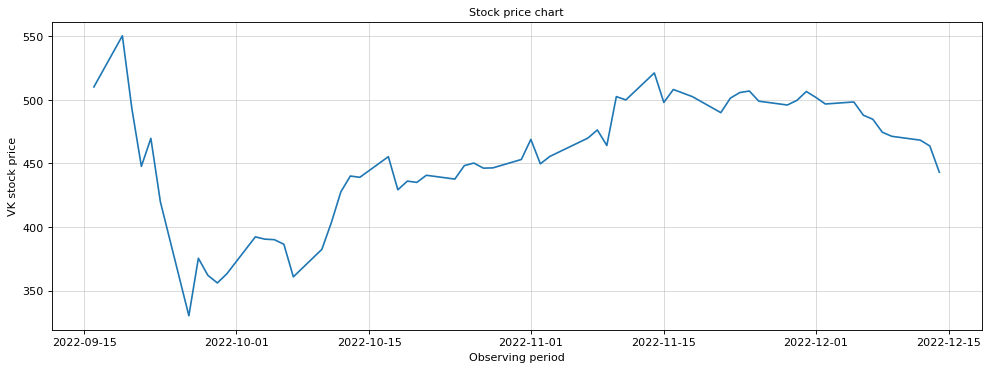

In [2]:
# calculating returns for period
period_return = round(stockPrice[-1] / stockPrice[0] - 1, 3)

#result for stock price
print('Stock price first observing day:', stockPrice[0])
print('Stock price last observing day:', stockPrice[-1])
print('Period returns:', period_return)

# plotting stock prcies
plt.figure(figsize=(15,5), dpi=80) 
plt.plot(stockPrice)
plt.ylabel('VK stock price')
plt.xlabel('Observing period')
plt.title('Stock price chart', size=10)
plt.grid(axis='both', alpha=.5)
plt.show() 

mean daily returns: -0.025, daily volatility: 5.041, monthly volatility 23
Q1: -1.036, Q3: 2.049, Median: -0.227, Maximum loses -21.343, Maximal returns 13.689
Confidence interval: (-1.2903895649638288, 1.2395600551993158)


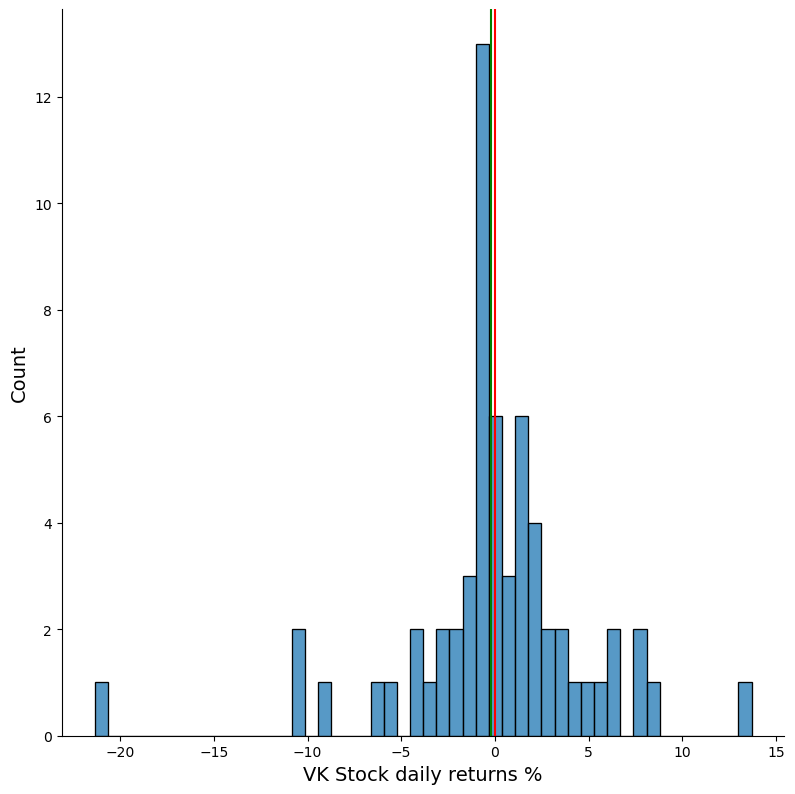

In [3]:
import math 
import seaborn as sns
import scipy.stats as st

#calculating daily returns
returns = stockPrice.pct_change()*100
returns = returns[1:-1] # daily returns

#calculating statistics for returns
mean_daily_returns = round(returns.mean(), 3) #average daily returns
daily_volatility = round(returns.std(), 3) #daily volatility
monthly_volatility = round(returns.std()*math.sqrt(21)) #monthly volatility
Q1 = round(returns.quantile(0.25), 3) #25% of returns observations are not higher than value
Q3 = round(returns.quantile(0.75), 3) #75% of returns observations are not higher than value
Median = round(returns.median(), 3) #50% of returns observations are not higher
Min = round(returns.min(), 3) #minimal returns (maximal loses)
Max = round(returns.max(), 3) #maximal returns 
Confidence_interval = st.norm.interval(confidence=0.95, 
                                       loc=np.mean(returns), 
                                       scale=st.sem(returns)) #calculcating confidence interval at 0,05 confidence level


print(f'''mean daily returns: {mean_daily_returns}, daily volatility: {daily_volatility}, monthly volatility {monthly_volatility}''')
print(f'''Q1: {Q1}, Q3: {Q3}, Median: {Median}, Maximum loses {Min}, Maximal returns {Max}''')
print(f'''Confidence interval: {Confidence_interval}''')

#histogram for daily returns
sns.displot(returns, bins=50, height=8)
plt.xlabel("VK Stock daily returns %", size=14)
plt.ylabel("Count", size=14)
plt.axvline(x=returns.mean(), color='red')
plt.axvline(x=returns.median(), color='green')
plt.show()